In [5]:
import os
import sys
current = os.path.dirname(os.path.realpath("single_neuron_edit.ipynb"))
parent = os.path.dirname(current)
sys.path.append(parent)
import copy
from time import perf_counter
import dill
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F
import os.path
from tqdm import trange
import dnnlib
import styleganxl.legacy
from styleganxl import metric_utils
import timm
import timm.models.vision_transformer
from styleganxl.diffaug import DiffAugment
from pg_modules.blocks import Interpolate
from transformers import CLIPProcessor, CLIPModel
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import clip
from PIL import Image
import requests
import time
import pickle
import math
import tensorflow
from mae import load_mae
from match_utils import matching, stats, nethook, dataset, loading, plotting, layers, universal, models

### Loads models, tables, matches

In [2]:
num_steps=500
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_learning_rate = 0.001
classs = 226

device = 'cuda:0'
device = torch.device(device)

discr_mode = 'clip'
discr, _ = clip.load("RN50", device=device)
discr_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
for p in discr.parameters():
    p.data = p.data.float()

# Load GAN.
G, gan_layers = models.load_gan('styleganxl', device=device)
ganlayers, discrlayers = layers.get_layers(G,gan_layers, discr, discr_layers,"styleganxl", discr_mode, device)

G = nethook.InstrumentedModel(G)
G.retain_layers(gan_layers, detach = False)

discr = nethook.InstrumentedModel(discr)
discr.retain_layers(discr_layers)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done


In [ ]:
universal_matches, stats = universal.get_universal_activations("matches/results_226_resnet50_styleganxl",
                          "matches/results_226_mae_styleganxl",
                          "matches/results_226_dino_styleganxl", 
                          "matches/results_226_dinovitb16_styleganxl",
                          "matches/results_226_clip_styleganxl",
                           device = device, n = 10)
for i, j in universal_matches.items():
    perfect_matches.append(i)
    discr_perfect_matches.append(j[-1])

for i, unit in enumerate(perfect_matches):
    perfect_matches[i] = layers.find_act(perfect_matches[i], ganlayers)

In [380]:
z_sample_count = 1

z_samples = torch.from_numpy(np.random.randn(z_sample_count, G.model.z_dim)).to(device)
c_samples = np.zeros([z_sample_count, G.model.c_dim], dtype=np.float32)
c_samples[:, classs] = 1
c_samples = torch.from_numpy(c_samples).to(device)

w_samples = G.model.mapping(z_samples, c_samples)  # [N, L, C]

# get empirical w_avg

w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
w_samples = G.model.mapping(z_samples, c_samples)  # [N, L, C]

# get empirical w_avg
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]


In [381]:
w_src = torch.tensor(copy.deepcopy(w_avg), dtype=torch.float32, device=device, requires_grad=False).to(device)
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True).to(device) # pylint: disable=not-callable
optimizer = torch.optim.Adam([w_opt], betas=(0.9, 0.999), lr=initial_learning_rate)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


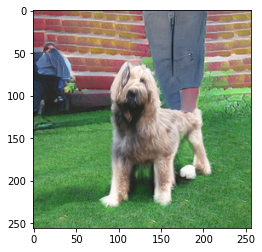

In [382]:
init = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')
init = (init.detach().cpu()+1)/2
init = torch.permute(init[0], (1,2,0))
plt.imshow(init)
init = (init-torch.min(init))/(torch.max(init)-torch.min(init))
init = np.uint8(init*255)

In [383]:
gan_activs = matching.store_activs(G, gan_layers)

eps = 0.00001
for i,_ in enumerate(gan_activs):
    gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)
    
gan_perfect_activs = []
for idx in perfect_matches:
    gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])


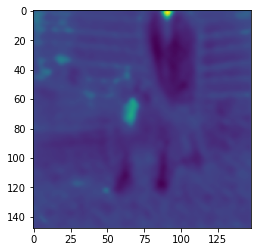

In [384]:
init = gan_perfect_activs[5]
plt.imshow(init[0].cpu().detach().double())

In [385]:
maxx = torch.max(ref)

torch.Size([1, 148, 148])


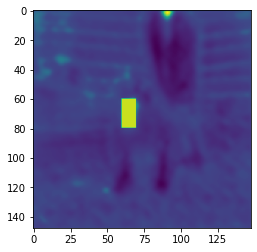

In [386]:
ref = init.clone()
ref[0,60:80, 60:70] = 3*maxx
plt.imshow(ref[0].detach().cpu())
ref = ref.unsqueeze(0).detach()

-0.10818908296385109
[ step    1/500] 


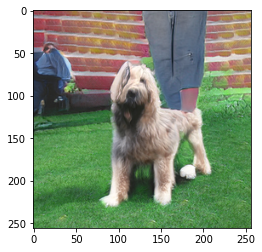

-0.10818908296385109
[ step    2/500] 
-0.10873396182289627
[ step    3/500] 
-0.10967098866711424
[ step    4/500] 
-0.11116368920347758
[ step    5/500] 
-0.1129779784739671
[ step    6/500] 
-0.11543358714440252
[ step    7/500] 
-0.11836333955318389
[ step    8/500] 
-0.12180292560770124
[ step    9/500] 
-0.12566937440746992
[ step   10/500] 
-0.13026135745916656
[ step   11/500] 


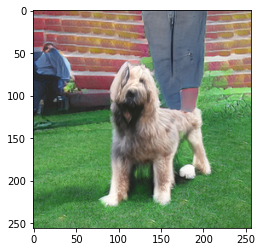

-0.13593175822385115
[ step   12/500] 
-0.14211693432545328
[ step   13/500] 
-0.1485740365138037
[ step   14/500] 
-0.15564315506942195
[ step   15/500] 
-0.16354093200500022
[ step   16/500] 
-0.17262034627399941
[ step   17/500] 
-0.18191853723857646
[ step   18/500] 
-0.19380003651133268
[ step   19/500] 
-0.2064724955875578
[ step   20/500] 
-0.2208748523151075
[ step   21/500] 


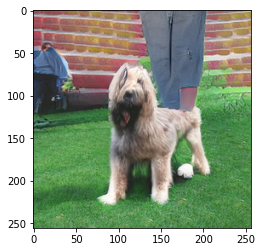

-0.2355248464786652
[ step   22/500] 
-0.2515667142086986
[ step   23/500] 
-0.268066529056243
[ step   24/500] 
-0.2849545183721647
[ step   25/500] 
-0.3030723015288904
[ step   26/500] 
-0.32086070845141523
[ step   27/500] 
-0.339198029923672
[ step   28/500] 
-0.3572838285835291
[ step   29/500] 
-0.3738430010134042
[ step   30/500] 
-0.38977805614931027
[ step   31/500] 


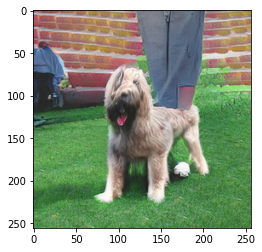

-0.4051907264081752
[ step   32/500] 
-0.41854554530793864
[ step   33/500] 
-0.4312186070726321
[ step   34/500] 
-0.4445516013333276
[ step   35/500] 
-0.45630278804321184
[ step   36/500] 
-0.4670011967443551
[ step   37/500] 
-0.4772420830609694
[ step   38/500] 
-0.4869048575050652
[ step   39/500] 
-0.49612801325525596
[ step   40/500] 
-0.5046475183695551
[ step   41/500] 


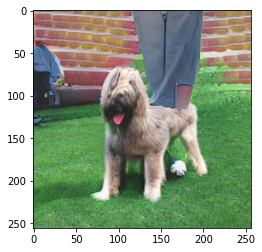

-0.5127069693403241
[ step   42/500] 
-0.5190972674355782
[ step   43/500] 
-0.5254812821167719
[ step   44/500] 
-0.5312068300807545
[ step   45/500] 
-0.536430960607597
[ step   46/500] 
-0.541150280349663
[ step   47/500] 
-0.5455271459977319
[ step   48/500] 
-0.5493778049004305
[ step   49/500] 
-0.5530349467313402
[ step   50/500] 
-0.5567705132151075
[ step   51/500] 


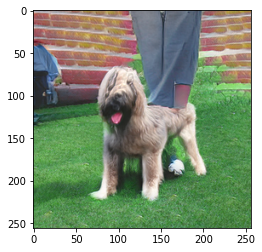

-0.5599499546092322
[ step   52/500] 
-0.5633823415379012
[ step   53/500] 
-0.566757670752246
[ step   54/500] 
-0.5701734424362154
[ step   55/500] 
-0.5733224600219007
[ step   56/500] 
-0.5763257657535438
[ step   57/500] 
-0.5793860275363077
[ step   58/500] 
-0.5822412312192206
[ step   59/500] 
-0.5847835465934321
[ step   60/500] 
-0.587548849546077
[ step   61/500] 


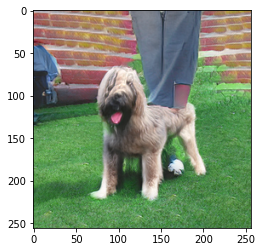

-0.5901382570659021
[ step   62/500] 
-0.5926583887497414
[ step   63/500] 
-0.5949776137334251
[ step   64/500] 
-0.5973485990174711
[ step   65/500] 
-0.5996455001577355
[ step   66/500] 
-0.6016974139134744
[ step   67/500] 
-0.6036894301415022
[ step   68/500] 
-0.6057209714467138
[ step   69/500] 
-0.6074535436582634
[ step   70/500] 
-0.6093835165519911
[ step   71/500] 


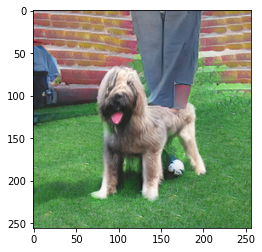

-0.6112171402998858
[ step   72/500] 
-0.6127317497390132
[ step   73/500] 
-0.61451737585298
[ step   74/500] 
-0.6160848246444233
[ step   75/500] 
-0.6177918859995849
[ step   76/500] 
-0.6195231424347714
[ step   77/500] 
-0.6209024898454477
[ step   78/500] 
-0.6224604680437502
[ step   79/500] 
-0.6239454417643906
[ step   80/500] 
-0.6254988025272529
[ step   81/500] 


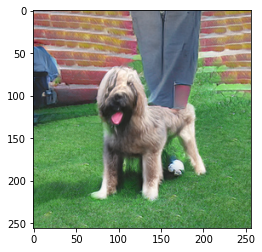

-0.6267434452560376
[ step   82/500] 
-0.6281987656951344
[ step   83/500] 
-0.6296374735169078
[ step   84/500] 
-0.6309860965263575
[ step   85/500] 
-0.6322891537919064
[ step   86/500] 
-0.6335978604272339
[ step   87/500] 
-0.6348355977764131
[ step   88/500] 
-0.6361727791773558
[ step   89/500] 
-0.6373610124529663
[ step   90/500] 
-0.6384372297397662
[ step   91/500] 


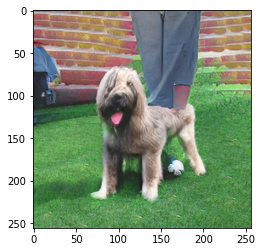

-0.6396690200246526
[ step   92/500] 
-0.6407633315751265
[ step   93/500] 
-0.6419535619626928
[ step   94/500] 
-0.6432166472262565
[ step   95/500] 
-0.6442007381959198
[ step   96/500] 
-0.6450903462347607
[ step   97/500] 
-0.6465133932723549
[ step   98/500] 
-0.6476755052838232
[ step   99/500] 
-0.6487913594297122
[ step  100/500] 
-0.6497602516902585
[ step  101/500] 


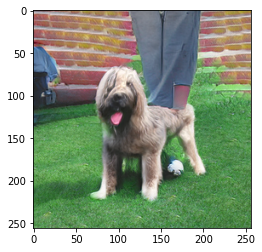

-0.6507732110653232
[ step  102/500] 
-0.6517132527286388
[ step  103/500] 
-0.6527540159391368
[ step  104/500] 
-0.6538018496311957
[ step  105/500] 
-0.6547181412488248
[ step  106/500] 
-0.6557377714625958
[ step  107/500] 
-0.6567732977950835
[ step  108/500] 
-0.6577673512458948
[ step  109/500] 
-0.6586642274943824
[ step  110/500] 
-0.6595925297459763
[ step  111/500] 


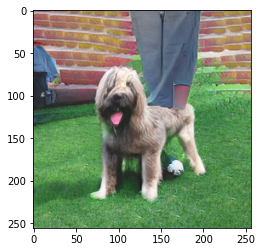

-0.6603848493568842
[ step  112/500] 
-0.6610487401495283
[ step  113/500] 
-0.6620136624524243
[ step  114/500] 
-0.6630671532741469
[ step  115/500] 
-0.663917867889436
[ step  116/500] 
-0.6647542712778759
[ step  117/500] 
-0.6658358358374143
[ step  118/500] 
-0.6667643203986083
[ step  119/500] 
-0.6676790334447916
[ step  120/500] 
-0.6685159449905446
[ step  121/500] 


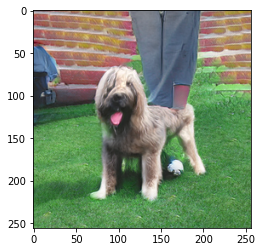

-0.6695163976083288
[ step  122/500] 
-0.6701782272536164
[ step  123/500] 
-0.6711243718169662
[ step  124/500] 
-0.672152934552391
[ step  125/500] 
-0.6728402787008031
[ step  126/500] 
-0.6738997250325038
[ step  127/500] 
-0.6747944956238537
[ step  128/500] 
-0.6757699507763532
[ step  129/500] 
-0.6765899634169525
[ step  130/500] 
-0.6775985606124499
[ step  131/500] 


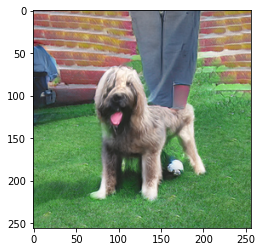

-0.6783638734593931
[ step  132/500] 
-0.6792849696032421
[ step  133/500] 
-0.6802681842840735
[ step  134/500] 
-0.6810497689734285
[ step  135/500] 
-0.682059071209388
[ step  136/500] 
-0.6830633163747379
[ step  137/500] 
-0.6841053232117504
[ step  138/500] 
-0.6849050822784147
[ step  139/500] 
-0.6858191872678762
[ step  140/500] 
-0.6866007630347641
[ step  141/500] 


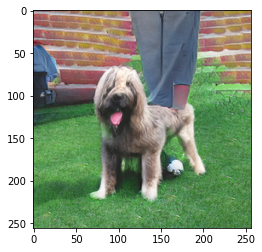

-0.6876643498307599
[ step  142/500] 
-0.6887850893226913
[ step  143/500] 
-0.6895565950126451
[ step  144/500] 
-0.690541014462474
[ step  145/500] 
-0.6914668023306012
[ step  146/500] 
-0.6924115522571098
[ step  147/500] 
-0.6934469283869601
[ step  148/500] 
-0.6945467405504524
[ step  149/500] 
-0.6955767783422548
[ step  150/500] 
-0.6967743172467931
[ step  151/500] 


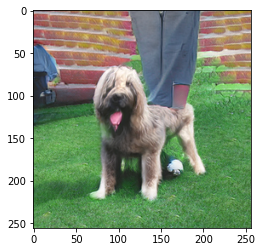

-0.6977176027161806
[ step  152/500] 
-0.699087202531235
[ step  153/500] 
-0.7000573678564946
[ step  154/500] 
-0.700980190835957
[ step  155/500] 
-0.7019902318721455
[ step  156/500] 
-0.7032079876470472
[ step  157/500] 
-0.7044402582633863
[ step  158/500] 
-0.7055120846218302
[ step  159/500] 
-0.7066512034108006
[ step  160/500] 
-0.7074643021560935
[ step  161/500] 


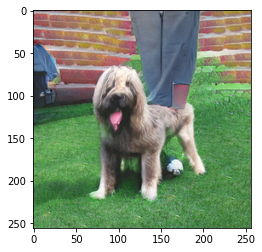

-0.7086334833674748
[ step  162/500] 
-0.7096629758703558
[ step  163/500] 
-0.7106959199753861
[ step  164/500] 
-0.7118993293347192
[ step  165/500] 
-0.712982033040926
[ step  166/500] 
-0.7139690970768867
[ step  167/500] 
-0.7151237393312588
[ step  168/500] 
-0.715944540107198
[ step  169/500] 
-0.7170161292915385
[ step  170/500] 
-0.7178580615303323
[ step  171/500] 


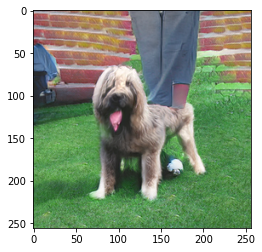

-0.7189239184596194
[ step  172/500] 
-0.7199388307351108
[ step  173/500] 
-0.7207890457877004
[ step  174/500] 
-0.7218233938145253
[ step  175/500] 
-0.7227598414543582
[ step  176/500] 
-0.7236735923856855
[ step  177/500] 
-0.7247199399246727
[ step  178/500] 
-0.7254519333608968
[ step  179/500] 
-0.7262702029884229
[ step  180/500] 
-0.7272294392617089
[ step  181/500] 


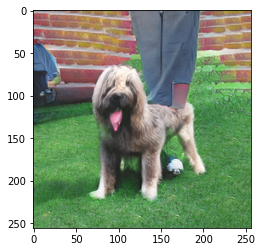

-0.7280667117590042
[ step  182/500] 
-0.7290103646308244
[ step  183/500] 
-0.7298338981677157
[ step  184/500] 
-0.7306155357285589
[ step  185/500] 
-0.7314966386578682
[ step  186/500] 
-0.7320931964295108
[ step  187/500] 
-0.7328847359149011
[ step  188/500] 
-0.7337666217428492
[ step  189/500] 
-0.7345706564514458
[ step  190/500] 
-0.7352938514357402
[ step  191/500] 


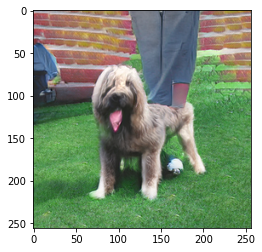

-0.7362387257211688
[ step  192/500] 
-0.7370987299811665
[ step  193/500] 
-0.7379541286086081
[ step  194/500] 
-0.7387262878422198
[ step  195/500] 
-0.7396100610874071
[ step  196/500] 
-0.7404182537309026
[ step  197/500] 
-0.7412463880772177
[ step  198/500] 
-0.7421123426176764
[ step  199/500] 
-0.7428159929882937
[ step  200/500] 
-0.7439743489797175
[ step  201/500] 


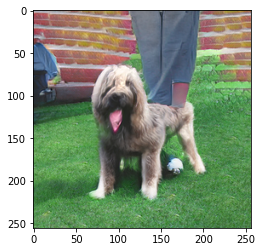

-0.7447064987697787
[ step  202/500] 
-0.745684359381498
[ step  203/500] 
-0.7463518480813862
[ step  204/500] 
-0.7472076396283515
[ step  205/500] 
-0.7478920641224164
[ step  206/500] 
-0.7487862597122634
[ step  207/500] 
-0.7494257352031557
[ step  208/500] 
-0.7502418037307803
[ step  209/500] 
-0.7510366829010369
[ step  210/500] 
-0.7517562677867049
[ step  211/500] 


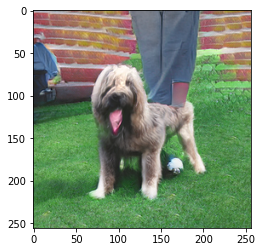

-0.7522681784829435
[ step  212/500] 
-0.7528052973263581
[ step  213/500] 
-0.7534469189586739
[ step  214/500] 
-0.7540063221802744
[ step  215/500] 
-0.7545577888894277
[ step  216/500] 
-0.7550525426775221
[ step  217/500] 
-0.755552022031906
[ step  218/500] 
-0.7561611632728024
[ step  219/500] 
-0.7565377870444888
[ step  220/500] 
-0.7570528756610718
[ step  221/500] 


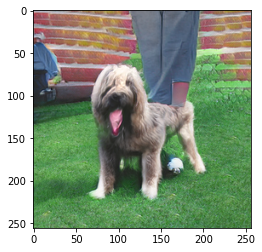

-0.7573918793101895
[ step  222/500] 
-0.7577576524817631
[ step  223/500] 
-0.7584998890095
[ step  224/500] 
-0.758972175607703
[ step  225/500] 
-0.7591317118343868
[ step  226/500] 
-0.7596567279440797
[ step  227/500] 
-0.759919714918927
[ step  228/500] 
-0.7602423674766275
[ step  229/500] 
-0.76064781476112
[ step  230/500] 
-0.7609384379966571
[ step  231/500] 


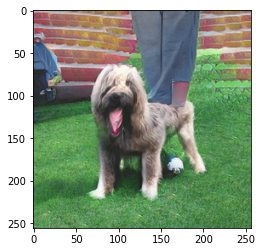

-0.7612804556486645
[ step  232/500] 
-0.7618864140301954
[ step  233/500] 
-0.7621973491340575
[ step  234/500] 
-0.7625792981523869
[ step  235/500] 
-0.7628775225904422
[ step  236/500] 
-0.7630805032336477
[ step  237/500] 
-0.7635214352631532
[ step  238/500] 
-0.763905104445671
[ step  239/500] 
-0.7640724019457503
[ step  240/500] 
-0.764320199117785
[ step  241/500] 


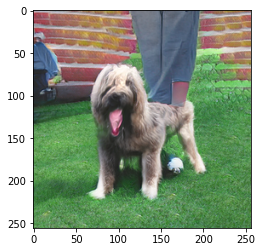

-0.7647890782910152
[ step  242/500] 
-0.7649861784822222
[ step  243/500] 
-0.7651064757407104
[ step  244/500] 
-0.7655733719022699
[ step  245/500] 
-0.7654687138458921
[ step  246/500] 
-0.7656522975846511
[ step  247/500] 
-0.7658602055913268
[ step  248/500] 
-0.7661436560714834
[ step  249/500] 
-0.7660718378482694
[ step  250/500] 
-0.7664927263877932
[ step  251/500] 


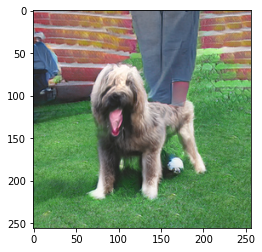

-0.7665087783270219
[ step  252/500] 
-0.7666977093862516
[ step  253/500] 
-0.7667808167012043
[ step  254/500] 
-0.7670097079382673
[ step  255/500] 
-0.7670719808713959
[ step  256/500] 
-0.7671402093080416
[ step  257/500] 
-0.7672317949356117
[ step  258/500] 
-0.7674823996585073
[ step  259/500] 
-0.767771735787501
[ step  260/500] 
-0.7678393590082823
[ step  261/500] 


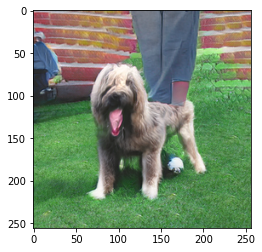

-0.7680431385278249
[ step  262/500] 
-0.7680347676288404
[ step  263/500] 
-0.7681286883165342
[ step  264/500] 
-0.7681411892871033
[ step  265/500] 
-0.7681996292297918
[ step  266/500] 
-0.7682048670272986
[ step  267/500] 
-0.7682674500691051
[ step  268/500] 
-0.768360128913396
[ step  269/500] 
-0.7683972954359111
[ step  270/500] 
-0.7686199031846047
[ step  271/500] 


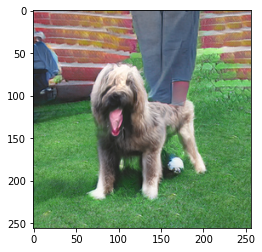

-0.7686050892961823
[ step  272/500] 
-0.7686233663516138
[ step  273/500] 
-0.7687459950560931
[ step  274/500] 
-0.768724538246454
[ step  275/500] 
-0.7688973182873767
[ step  276/500] 
-0.7688975910977659
[ step  277/500] 
-0.7689200817666323
[ step  278/500] 
-0.7688449670947743
[ step  279/500] 
-0.7692998076303064
[ step  280/500] 
-0.7692208809931667
[ step  281/500] 


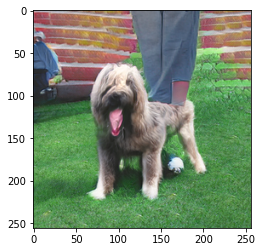

-0.7692213650971462
[ step  282/500] 
-0.7691800198592196
[ step  283/500] 
-0.7692161192409382
[ step  284/500] 
-0.769307425345673
[ step  285/500] 
-0.7692016254773036
[ step  286/500] 
-0.7693331266159978
[ step  287/500] 
-0.7692596468475054
[ step  288/500] 
-0.7692501676466776
[ step  289/500] 
-0.7693872101604671
[ step  290/500] 
-0.7693265665797782
[ step  291/500] 


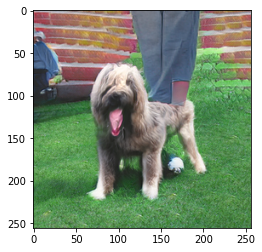

-0.7692905761696601
[ step  292/500] 
-0.7692464723392394
[ step  293/500] 
-0.7691978211197957
[ step  294/500] 
-0.7693353056743697
[ step  295/500] 
-0.7693970839800937
[ step  296/500] 
-0.7693432840008637
[ step  297/500] 
-0.7693179595908197
[ step  298/500] 
-0.7694540035470238
[ step  299/500] 
-0.7693759910781276
[ step  300/500] 
-0.7695263928989183
[ step  301/500] 


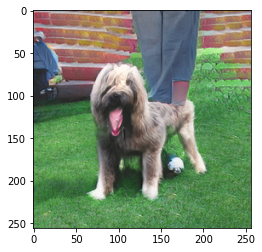

-0.7694157050998875
[ step  302/500] 
-0.7696147504713992
[ step  303/500] 
-0.7695954535379361
[ step  304/500] 
-0.7695264408600793
[ step  305/500] 
-0.7694145301791863
[ step  306/500] 
-0.7694547808110859
[ step  307/500] 
-0.7694466269712634
[ step  308/500] 
-0.7694236140367107
[ step  309/500] 
-0.7695014805484264
[ step  310/500] 
-0.7694674581812898
[ step  311/500] 


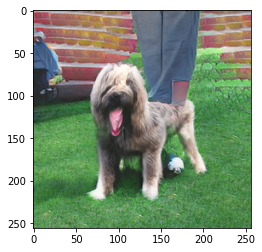

-0.7695352149246479
[ step  312/500] 
-0.7695993433439196
[ step  313/500] 
-0.7695937600757765
[ step  314/500] 
-0.769556815856945
[ step  315/500] 
-0.769582804567827
[ step  316/500] 
-0.7695141615461468
[ step  317/500] 
-0.7695829873008544
[ step  318/500] 
-0.7696983610305421
[ step  319/500] 
-0.7698302420127683
[ step  320/500] 
-0.7697010495296889
[ step  321/500] 


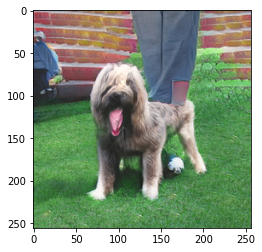

-0.7699681150000103
[ step  322/500] 
-0.7698238785942275
[ step  323/500] 
-0.7698920812837371
[ step  324/500] 
-0.7698547811932862
[ step  325/500] 
-0.7699275608609986
[ step  326/500] 
-0.7699226768963678
[ step  327/500] 
-0.7698088750437807
[ step  328/500] 
-0.769720519546318
[ step  329/500] 
-0.7697681730953915
[ step  330/500] 
-0.7697539637772768
[ step  331/500] 


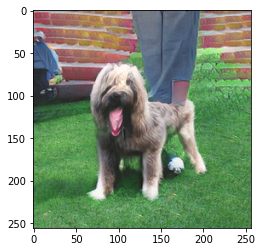

-0.769674434471505
[ step  332/500] 
-0.7697456963781043
[ step  333/500] 
-0.7698618847408859
[ step  334/500] 
-0.7698351048817076
[ step  335/500] 
-0.7697878964625864
[ step  336/500] 
-0.7697517802299811
[ step  337/500] 
-0.7697456448616516
[ step  338/500] 
-0.7698005303426825
[ step  339/500] 
-0.7698097942489326
[ step  340/500] 
-0.76982986711722
[ step  341/500] 


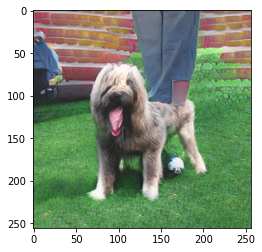

-0.7699156326073233
[ step  342/500] 
-0.769953749619988
[ step  343/500] 
-0.7699935669829302
[ step  344/500] 
-0.7701373612099792
[ step  345/500] 
-0.7701014354069955
[ step  346/500] 
-0.770065086521908
[ step  347/500] 
-0.7701085729930662
[ step  348/500] 
-0.7700232232579615
[ step  349/500] 
-0.7701626275001727
[ step  350/500] 
-0.7701096111199659
[ step  351/500] 


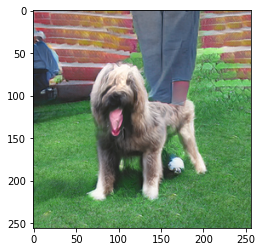

-0.7703840661158398
[ step  352/500] 
-0.7703189072022267
[ step  353/500] 
-0.770292118633072
[ step  354/500] 
-0.7703356464348725
[ step  355/500] 
-0.7702691495168223
[ step  356/500] 
-0.7704929885748567
[ step  357/500] 
-0.7704352240625659
[ step  358/500] 
-0.7704328674670966
[ step  359/500] 
-0.7706423581387988
[ step  360/500] 
-0.7705077975108223
[ step  361/500] 


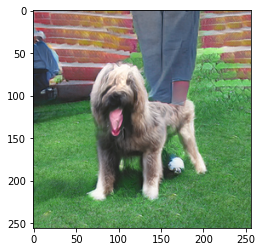

-0.7706211808079884
[ step  362/500] 
-0.7706096647266136
[ step  363/500] 
-0.7706631284400648
[ step  364/500] 
-0.7707434351989242
[ step  365/500] 
-0.7706880559203377
[ step  366/500] 
-0.77088698580911
[ step  367/500] 
-0.7707520178335444
[ step  368/500] 
-0.7709169270339522
[ step  369/500] 
-0.7708387093581237
[ step  370/500] 
-0.7708539262822403
[ step  371/500] 


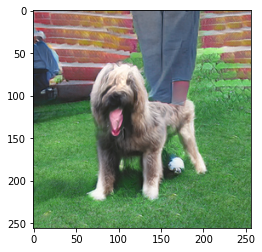

-0.7710120551372446
[ step  372/500] 
-0.7710070099538877
[ step  373/500] 
-0.7710279773286274
[ step  374/500] 
-0.7710655175977839
[ step  375/500] 
-0.7710965632262314
[ step  376/500] 
-0.7709142738702005
[ step  377/500] 
-0.7710866465333364
[ step  378/500] 
-0.77095366563952
[ step  379/500] 
-0.7710355678300402
[ step  380/500] 
-0.7709948121386012
[ step  381/500] 


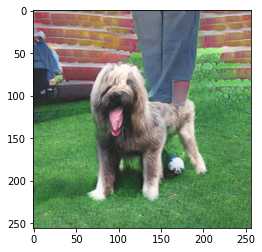

-0.771049623387726
[ step  382/500] 
-0.7709262207901401
[ step  383/500] 
-0.771006201818519
[ step  384/500] 
-0.77106704286128
[ step  385/500] 
-0.7710278023437631
[ step  386/500] 
-0.7709786316488608
[ step  387/500] 
-0.7711293727466313
[ step  388/500] 
-0.7709294396647509
[ step  389/500] 
-0.7709874863178868
[ step  390/500] 
-0.7710062310320437
[ step  391/500] 


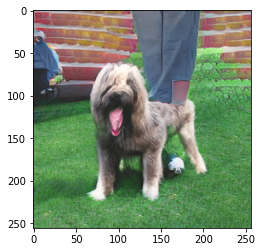

-0.7709001793726731
[ step  392/500] 
-0.770924107651239
[ step  393/500] 
-0.7710230505233203
[ step  394/500] 
-0.7710408369495798
[ step  395/500] 
-0.7709744614732486
[ step  396/500] 
-0.7709881458798188
[ step  397/500] 
-0.7709940932336424
[ step  398/500] 
-0.7710509778793051
[ step  399/500] 
-0.7710171906343313
[ step  400/500] 
-0.7710270911477793
[ step  401/500] 


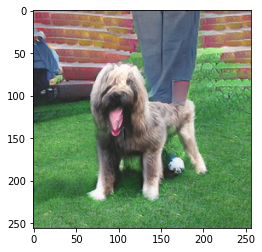

-0.7710523733727426
[ step  402/500] 
-0.7709639107934562
[ step  403/500] 
-0.7710546435336502
[ step  404/500] 
-0.7710461542790938
[ step  405/500] 
-0.7710966174677383
[ step  406/500] 
-0.771141972255237
[ step  407/500] 
-0.7711220022235404
[ step  408/500] 
-0.7711961851687658
[ step  409/500] 
-0.7711380187378633
[ step  410/500] 
-0.7710399068820872
[ step  411/500] 


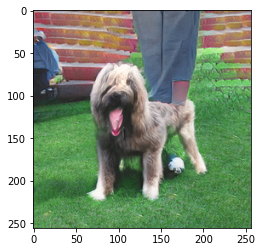

-0.7710869954210275
[ step  412/500] 
-0.771046409418927
[ step  413/500] 
-0.7711466404933414
[ step  414/500] 
-0.7711398513882737
[ step  415/500] 
-0.7710358104730016
[ step  416/500] 
-0.7710898493428038
[ step  417/500] 
-0.7710959639776135
[ step  418/500] 
-0.7710547408596972
[ step  419/500] 
-0.7711496019155968
[ step  420/500] 
-0.7709588699603469
[ step  421/500] 


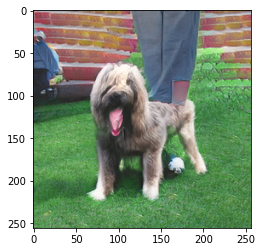

-0.771121514017476
[ step  422/500] 
-0.7711483880428114
[ step  423/500] 
-0.7711418770945508
[ step  424/500] 
-0.7710969495985907
[ step  425/500] 
-0.7710218376066841
[ step  426/500] 
-0.7710972706921914
[ step  427/500] 
-0.7710719620926731
[ step  428/500] 
-0.771176620673771
[ step  429/500] 
-0.7712038153879588
[ step  430/500] 
-0.7711299149832022
[ step  431/500] 


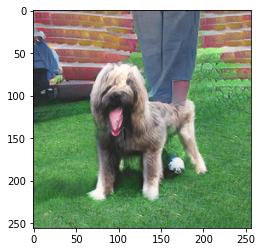

-0.7710466856924573
[ step  432/500] 
-0.7710982406177752
[ step  433/500] 
-0.7711732453869329
[ step  434/500] 
-0.7711993975427164
[ step  435/500] 
-0.7710855222327718
[ step  436/500] 
-0.7711063221244674
[ step  437/500] 
-0.7711560865924101
[ step  438/500] 
-0.771097108640546
[ step  439/500] 
-0.7711819224091206
[ step  440/500] 
-0.7711178613052871
[ step  441/500] 


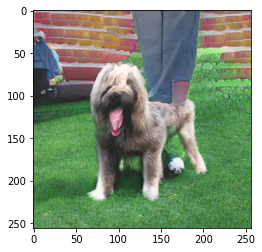

-0.7710900638642357
[ step  442/500] 
-0.7711295766227962
[ step  443/500] 
-0.771044092296921
[ step  444/500] 
-0.7710762795935994
[ step  445/500] 
-0.7710821369427485
[ step  446/500] 
-0.7710634969954173
[ step  447/500] 
-0.7710745177719805
[ step  448/500] 
-0.7711285911233693
[ step  449/500] 
-0.7711266637620683
[ step  450/500] 
-0.7711421420134721
[ step  451/500] 


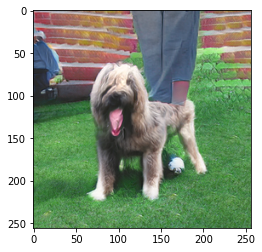

-0.7710620045506074
[ step  452/500] 
-0.7710948162034421
[ step  453/500] 
-0.7710629661128356
[ step  454/500] 
-0.7710308734990383
[ step  455/500] 
-0.7710354052596224
[ step  456/500] 
-0.771130990387992
[ step  457/500] 
-0.7710234274055071
[ step  458/500] 
-0.7710763658659081
[ step  459/500] 
-0.7709604183789771
[ step  460/500] 
-0.7710676667221965
[ step  461/500] 


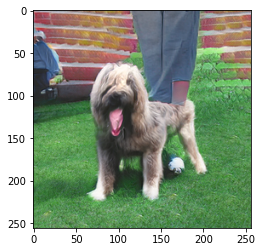

-0.771093270283048
[ step  462/500] 
-0.7710817830275095
[ step  463/500] 
-0.7711221022356515
[ step  464/500] 
-0.7710197180120885
[ step  465/500] 
-0.7710284348251173
[ step  466/500] 
-0.7711256529626668
[ step  467/500] 
-0.7711233578242088
[ step  468/500] 
-0.7710969488095915
[ step  469/500] 
-0.7711743962100517
[ step  470/500] 
-0.7711358958345651
[ step  471/500] 


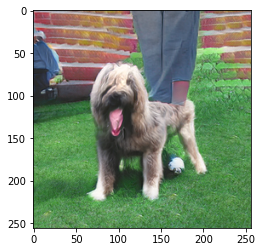

-0.7711593375035084
[ step  472/500] 
-0.7712293006362355
[ step  473/500] 
-0.771165510824801
[ step  474/500] 
-0.7711081328337704
[ step  475/500] 
-0.7711487052069467
[ step  476/500] 
-0.7710640988551364
[ step  477/500] 
-0.7711128623818387
[ step  478/500] 
-0.7710120109158505
[ step  479/500] 
-0.7710502428609202
[ step  480/500] 
-0.7711431758821328
[ step  481/500] 


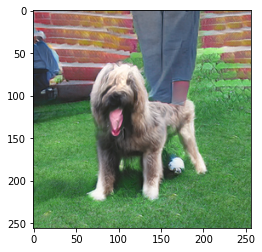

-0.7711050867483938
[ step  482/500] 
-0.7710296843445025
[ step  483/500] 
-0.7710423979028732
[ step  484/500] 
-0.7711828279879803
[ step  485/500] 
-0.771103665339489
[ step  486/500] 
-0.77108759665902
[ step  487/500] 
-0.7711279155822152
[ step  488/500] 
-0.7711880063167276
[ step  489/500] 
-0.7711645312931784
[ step  490/500] 
-0.7711116181165156
[ step  491/500] 


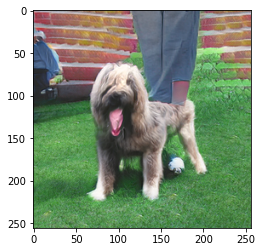

-0.7710995953842882
[ step  492/500] 
-0.7711036794427463
[ step  493/500] 
-0.771109396793232
[ step  494/500] 
-0.771060984947017
[ step  495/500] 
-0.7710621252082185
[ step  496/500] 
-0.7710589673032399
[ step  497/500] 
-0.7710640214590379
[ step  498/500] 
-0.7710681624746186
[ step  499/500] 
-0.7710792899220841
[ step  500/500] 


In [387]:
all_images = []
for step in range(num_steps):
    # Learning rate schedule.
    t = step / num_steps
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Synth images from z
    synth_images = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')


    # track images
    synth_images = (synth_images + 1) * (255/2)
    synth_images_np = synth_images.clone().detach().permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    all_images.append(synth_images_np)

    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')


    gan_activs = matching.store_activs(G, gan_layers)

    #normalize all activations
    eps = 0.00001
    for i,_ in enumerate(gan_activs):
        gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)

    gan_perfect_activs = []
    for idx in perfect_matches:
        gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])



    #pearson correlation
    a_loss = 0

    ### index into activation we are editing
    i = 35
    map_size = gan_perfect_activs[i]
    gan_activ_new = gan_perfect_activs[i].unsqueeze(0)
    prod = torch.einsum('aixy,ajxy->ij', gan_activ_new, ref)
    div1 = torch.sum(gan_activ_new**2)
    div2 = torch.sum(ref**2)
    corr = prod/torch.sqrt(div1*div2)
    a_loss += corr


    a_loss *= -1
    l_reg = torch.mean((w_src - w_opt)**2)
    loss = a_loss + 10 * l_reg

    # Step
    optimizer.zero_grad(set_to_none=True)

    loss.backward()
    optimizer.step()
    msg  = f'[ step {step+1:>4d}/{num_steps}] '
    print(a_loss.item())
    #msg += f'[ a_loss: {float(a_loss):5.2f} loss_reg: {0.1 * float(l_reg):5.2f}] '
    print(msg)
    if step % 10 == 0:
        plt.imshow(synth_images_np)
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


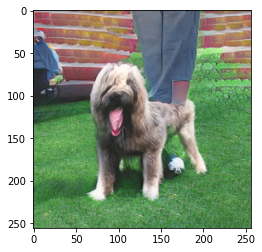

In [388]:
final = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')
#final, _ = G([z], 0.7, mean_latent)
final = (final.detach().cpu()+1)/2
final = torch.permute(final[0], (1,2,0))
plt.imshow(final)